In [1]:
# 5/16 20:50 時点のコード

from collections import Counter
from bs4 import BeautifulSoup
import pandas as pd
import re
import requests
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
from sklearn.metrics.pairwise import euclidean_distances

from scipy.spatial import Voronoi
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans

/Users/temju/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/__init__.py:21: UserWarning: A NumPy version >=1.22.4 and <2.3.0 is required for this version of SciPy (detected version 1.21.5)
  from scipy.sparse import issparse
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
# CSVファイルのパスを指定して読み込む
df = pd.read_csv('wikiにある色のデータを全て集めたデータのデータにRGBのデータもつけたデータ.csv')

In [3]:
# ここに神ニキの頻度情報を入れる
kami_nucc = pd.read_csv('nucc_colour_terms.csv')

In [4]:
# 使わん列落とす
df = df.drop(columns=['名前','備考','マンセル']).dropna(subset=['R', 'G', 'B'])

In [5]:
# 「漢字・英語」と「同色・混同色」を結合しちゃう
df['名前'] = df.apply(lambda row: row['漢字・英語'] + '・' + row['同色・混同色'] 
                                            if pd.notna(row['同色・混同色']) else row['漢字・英語'], axis=1)
df = df.drop(columns=['色','漢字・英語','同色・混同色'])

# 行番号を連続的な整数値にリセットする
df.reset_index(drop=True, inplace=True)

In [6]:
# ・で区切られてた名前を集合にしたい
def create_name_set(text):
    names = text.split('・')
    return set(names)

In [7]:
# したったった
df['名前'] = df['名前'].apply(create_name_set)

In [8]:
# RGB列の組み合わせを文字列として追加
df['RGB_key'] = df['R'].astype(str) + '/' + df['G'].astype(str) + '/' + df['B'].astype(str)

# RGB_key列をキーとしてdfをグループ化する
# color codeでよかったやんとは思ってる
grouped = df.groupby('RGB_key')

# 各グループ内の行番号のリスト
grouped_row_indices = grouped.apply(lambda x: x.index.tolist())

# 要素数が2以上のグループの行番号リストを抽出する
row_indices_with_multiple_occurrences = grouped_row_indices[grouped_row_indices.apply(len) >= 2]

# 結果
print(row_indices_with_multiple_occurrences)

RGB_key
0.0/105.0/86.0          [168, 404]
0.0/11.0/0.0            [444, 445]
0.0/111.0/134.0          [35, 644]
0.0/124.0/138.0         [137, 435]
0.0/174.0/149.0     [21, 339, 545]
                         ...      
90.0/185.0/193.0        [265, 317]
91.0/128.0/99.0         [152, 472]
92.0/59.0/84.0          [226, 613]
93.0/93.0/99.0          [335, 343]
94.0/124.0/133.0            [3, 7]
Length: 100, dtype: object


In [9]:
# 被ってるRGBの行を1つにしたい
# 草津に龍は二人もいらんねん

# 落とす行番号は格納していく
drop_list = []
# len(row_indices_with_multiple_occurrences)だけ走らせてー
for j in range(len(row_indices_with_multiple_occurrences)):
    name = df.iloc[row_indices_with_multiple_occurrences[j][0], 3]
    for k in range(1, len(row_indices_with_multiple_occurrences[j])):
        row_idx = row_indices_with_multiple_occurrences[j][k] # [137, 435, ...] の 435以降を取りたい
        name = name.union(df.iloc[row_idx, 3])
        drop_list.append(row_indices_with_multiple_occurrences[j][k])
    df.iloc[row_indices_with_multiple_occurrences[j][0], 3].update(name)
# さーつがいせよー
df = df.drop(drop_list)

# 改めてdfの行番号を連続的な整数値にリセット
df.reset_index(drop=True, inplace=True)

# RGB_keyはもはや不要
df = df.drop(columns=['RGB_key'])

In [10]:
# RGBをcolor codeに変換する
# ほんまに最初からcolor codeで良かったやんとは思ってる
def rgb_to_hex(r, g, b):
    return "#{:02X}{:02X}{:02X}".format(int(r), int(g), int(b))

In [11]:
# 各行に対してRGB値をカラーコードに変換し、新しい列を追加
df['色'] = df.apply(lambda row: rgb_to_hex(row['R'], row['G'], row['B']), axis=1)

In [12]:
df

,R,G,B,名前,色
0,93.0,129.0,101.0,"{almond green, 山葵色}",#5D8165
1,26.0,68.0,114.0,"{Paris blue, プルシアンブルーほか, Prussian Blueプルシア藍, C...",#1A4472
2,15.0,84.0,116.0,"{インディゴ, 藍色}",#0F5474
3,94.0,124.0,133.0,"{藍鼠, 藍気鼠}",#5E7C85
4,71.0,81.0,137.0,{藍錆色},#475189
...,...,...,...,...,...
549,101.0,194.0,148.0,{若竹色},#65C294
550,171.0,200.0,139.0,{若葉色},#ABC88B
551,157.0,210.0,156.0,{若緑},#9DD29C
552,166.0,199.0,142.0,{山葵色},#A6C78E


In [13]:
# kami_nuccからhex_codeごとにfreqの合計を計算
freq_sum = kami_nucc.groupby('hex_code')['freq'].sum().reset_index()

# hex_codeをインデックスに設定
freq_sum = freq_sum.set_index('hex_code')

# dfに新しい列を追加
df['頻度'] = df['色'].map(freq_sum['freq'])

print(df)

         R      G      B                                                 名前  \
0     93.0  129.0  101.0                                {almond green, 山葵色}   
1     26.0   68.0  114.0  {Paris blue, プルシアンブルーほか, Prussian Blueプルシア藍, C...   
2     15.0   84.0  116.0                                        {インディゴ, 藍色}   
3     94.0  124.0  133.0                                          {藍鼠, 藍気鼠}   
4     71.0   81.0  137.0                                              {藍錆色}   
..     ...    ...    ...                                                ...   
549  101.0  194.0  148.0                                              {若竹色}   
550  171.0  200.0  139.0                                              {若葉色}   
551  157.0  210.0  156.0                                               {若緑}   
552  166.0  199.0  142.0                                              {山葵色}   
553  123.0  191.0  234.0                                 {勿忘草色, フォゲットミーノット}   

           色   頻度  
0    #5D8165  0.0  
1    #1A447

In [14]:
# ここで色落とす
# plotの見栄えのために落とさない
#df = df.drop(columns=['色'])

In [15]:
# freqが1以上の行を抽出
filtered_df = df[df['頻度'] >= 1]

for i in range(len(filtered_df)):
    print(filtered_df.iloc[i])

R                   0.0
G                 103.0
B                 192.0
名前    {ブルー, 蒼, 青, 碧, 藍}
色               #0067C0
頻度                 71.0
Name: 12, dtype: object
R                    237.0
G                     26.0
B                     61.0
名前    {丹, 紅, 緋, 赤, レッド, 朱}
色                  #ED1A3D
頻度                    82.0
Name: 22, dtype: object
R        241.0
G         90.0
B         34.0
名前    {赤橙, 朱色}
色      #F15A22
頻度         1.0
Name: 28, dtype: object
R                                                 175.0
G                                                 223.0
B                                                 228.0
名前    {アクア, ウォーターブルー水縹, 水色, ウォーターブルー, aquaaqua blue,...
色                                               #AFDFE4
頻度                                                  2.0
Name: 33, dtype: object
R               152.0
G                81.0
B                75.0
名前    {ラセットブラウン, 小豆色}
色             #98514B
頻度                1.0
Name: 44, dtype: object
R        101.0
G

In [16]:
df.to_csv('kaminucc_df.csv', index=False)

In [17]:
# 全色座標化
coords_of_points = [(df.iloc[i,0],df.iloc[i,1],df.iloc[i,2]) for i in range(len(df))]

In [18]:
# 始点集合からの距離の和を計算
def sum_of_distance_from_set(point,starting_origins):
    sum_d = 0
    origin_coords = [(df.iloc[i,0],df.iloc[i,1],df.iloc[i,2]) for i in starting_origins]
    for origin in origin_coords:
        sum_d = sum_d + np.linalg.norm(np.array(point) - np.array(origin))
    return sum_d

In [19]:
# 与えられた点からの最大距離の点を計算
def farthest_point(point):
    distances = []
    point_coords = (df.iloc[point,0],df.iloc[point,1],df.iloc[point,2])
    for coord in coords_of_points:
        distances.append(np.linalg.norm(np.array(coord) - np.array(point_coords)))
    farthest_ind = np.argmax(distances)
    return farthest_ind

In [20]:
def calculate_centroid(origin_points):
    # 点の数
    n = len(origin_points)
    
    # 各次元の合計を初期化
    sum_x = sum_y = sum_z = 0
    
    # 各点の座標の合計を計算
    for point in origin_points:
        sum_x += df.iloc[point,[0]][0]
        sum_y += df.iloc[point,[1]][0]
        sum_z += df.iloc[point,[2]][0]
    
    # 各次元の平均を計算
    centroid_x = sum_x / n
    centroid_y = sum_y / n
    centroid_z = sum_z / n
    
    # 重心を返す
    return (centroid_x, centroid_y, centroid_z)

In [21]:
# 始点から最小距離の点を計算
def closest_from_point(origin_point):
    distances = []
    origin_coord = (df.iloc[origin_point,0],df.iloc[origin_point,1],df.iloc[origin_point,2])
    for coord in coords_of_points:
        distances.append(np.linalg.norm(np.array(coord) - np.array(origin_point)))
    closest_ind = np.argmin(distances)
    return closest_ind

In [22]:
# 距離の和を使ってstarting_origins からの最遠点を求める
def farthest_by_sum(starting_origins):
    distances = []
    origin_coords = [(df.iloc[i,0],df.iloc[i,1],df.iloc[i,2]) for i in starting_origins]
    for point in coords_of_points:
        distances.append(sum_of_distance_from_set(point,starting_origins))

    # 最も遠い点のインデックスを見つける
    farthest_point_index = -1
    max_distance = -1
    for i, distance in enumerate(distances):
        if i not in starting_origins and distance > max_distance:
            farthest_point_index = i
            max_distance = distance

    return farthest_point_index

In [23]:
# 重心を使ってstarting_origins からの最遠点を求める
def farthest_by_centroid(starting_origins):
    distances = []
    centroid = calculate_centroid(starting_origins)
    
    for coord in coords_of_points:
        distances.append(np.linalg.norm(np.array(coord) - np.array(centroid)))

    # 最も遠い点のインデックスを見つける
    farthest_point_index = -1
    max_distance = -1
    for i, distance in enumerate(distances):
        if i not in starting_origins and distance > max_distance:
            farthest_point_index = i
            max_distance = distance

    return farthest_point_index

In [24]:
# 半径を使ってstarting_origins からの最遠点を求める
# なぜかリストが返ってくるので[0][0]抜いてます
def farthest_by_radius(starting_origins):
    origin_coords = [(df.iloc[i,0],df.iloc[i,1],df.iloc[i,2]) for i in starting_origins]

    # 中心とする円の半径の初期値
    radius = 0
    previous_outlier_points = []

    while True:
        # 含まれない点を保持するリスト
        outlier_points = []

        for center_point in origin_coords:
            for idx,point in enumerate(coords_of_points):
                
                # 中心点に含まれる点は除外する
                if point in origin_coords:
                    continue
                
                # 中心とする円の半径で円を定義し、点が円の内側に含まれるかどうかをチェック
                distance = np.linalg.norm(np.array(center_point) - np.array(point))
                if distance > radius:
                    outlier_points.append((idx,point))

        # 含まれない点が1つになったらループを終了
        if len(outlier_points) == 0:
            # 直前の半径で含まれていた点のインデックスを返す
            return previous_outlier_points
        
        # 含まれない点が1つになるまで、円の半径を拡大
        radius += 1
        
        # 直前の状態を保持
        previous_outlier_points = outlier_points

    return previous_outlier_points#[0][0]

In [25]:
# 距離の和を用いて最遠点を表示し，starting_originsに追加する
def new_origins_by_sum(starting_origins):
    farthest_ind = farthest_by_sum(starting_origins)
    starting_origins.append(farthest_ind)
    return print(df.iloc[farthest_ind])

In [26]:
# 重心を用いて最遠点を表示し，starting_originsに追加する
def new_origins_by_centroid(starting_origins):
    farthest_ind = farthest_by_centroid(starting_origins)
    starting_origins.append(farthest_ind)
    return print(df.iloc[farthest_ind])

In [27]:
# 半径のやつ使って最遠点を表示し，starting_originsに追加する
# 多分バグわいてるしここで[0][0]つけてる
def new_origins_by_radius(starting_origins):
    farthest_ind = farthest_by_radius(starting_origins)[0][0]
    starting_origins.append(farthest_ind)
    return print(df.iloc[farthest_ind])

In [28]:
# 与えられた点をplot
def plot_colors(points):
    
    # color codeをその頂点の色にしたい
    colors = []
    for point in points:
        colors.append(df.loc[point,'色'])

    # 点のリスト
    points_3d = [(df.iloc[i,0],df.iloc[i,1],df.iloc[i,2]) for i in points]

    # プロット
    fig = plt.figure(figsize=(12,12))
    ax = fig.add_subplot(111, projection='3d')

    # 点をプロット
    ax.scatter(*zip(*points_3d), color=colors, s=50)  # sで点の大きさを指定
    
    # 軸の範囲の設定
    ax.set_xlim([0, 260])
    ax.set_ylim([0, 260])
    ax.set_zlim([0, 260])

    # 軸ラベルの設定
    ax.set_xlabel('R')
    ax.set_ylabel('G')
    ax.set_zlabel('B')

    # グリッドの表示
    ax.grid(True)

    # 視点の調整
    #ax.view_init(elev=30, azim=45)

    ax.set_title('Colors')

    return plt.show()

In [29]:
# とりあえず赤青緑はどこにおる
red_rows = df[df['名前'].apply(lambda x: '赤' in x)]
blue_rows = df[df['名前'].apply(lambda x: '青' in x)]
green_rows = df[df['名前'].apply(lambda x: '緑' in x)]
print(red_rows, blue_rows, green_rows) # ここっここー
#  535,454,492をベースの赤青緑として使用する

         R     G     B                    名前        色    頻度
22   237.0  26.0  61.0  {丹, 紅, 緋, 赤, レッド, 朱}  #ED1A3D  82.0
535  241.0  91.0  91.0              {赤, red}  #F15B5B  82.0        R      G      B                 名前        色    頻度
12   0.0  103.0  192.0  {ブルー, 蒼, 青, 碧, 藍}  #0067C0  71.0
454  0.0  125.0  197.0          {blue, 青}  #007DC5  71.0        R      G      B          名前        色    頻度
190  0.0  177.0  107.0  {緑, green}  #00B16B  43.0
492  0.0  128.0    0.0   {グリーン, 緑}  #008000  43.0
493  0.0  121.0   61.0      {翠, 緑}  #00793D  36.0


In [30]:
# 基本色
# RGB違うのに被ってるのも多々ある
# とりあえず名前でまとめてみる

basic_color_names = ['青', '青緑', '青紫', '赤', '赤紫', '黄色', '黄緑', '黄赤', '黄黄色', '緑', '黒', 'cyancyan blue', '白', '紫', '灰色']
basic_colors = []
for name in basic_color_names:
    k= [i for i, names_set in enumerate(df['名前']) if name in names_set]
    print(name, ':', k)
    basic_colors.append(k)

青 : [12, 454]
青緑 : [20]
青紫 : [21, 396]
赤 : [22, 535]
赤紫 : [31]
黄色 : [62]
黄緑 : [64]
黄赤 : [65, 136]
黄黄色 : [167]
緑 : [190, 492, 493]
黒 : [196, 452]
cyancyan blue : [254]
白 : [277, 474]
紫 : [388, 499]
灰色 : [45, 194, 382, 395]


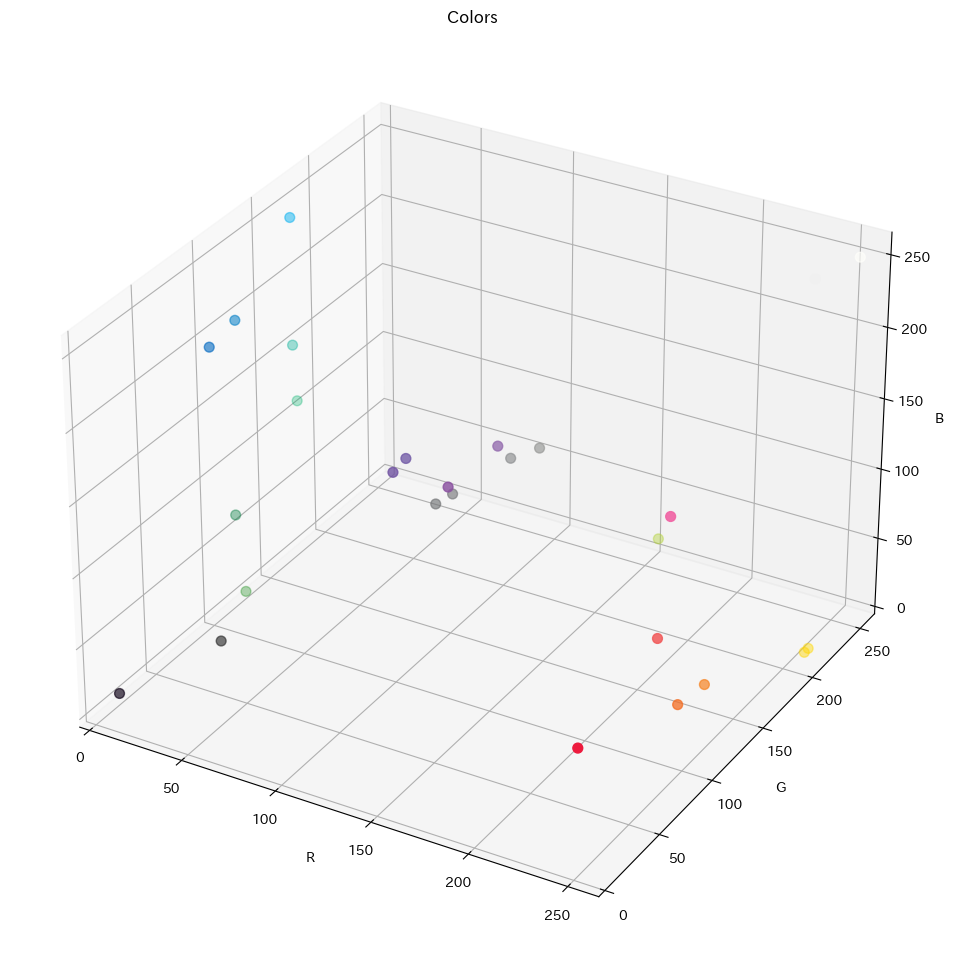

In [31]:
# 基本色のplot
# この散らばりが欲しい
basic_colors = [item for sublist in basic_colors for item in sublist]
plot_colors(basic_colors)

In [32]:
# 基本色達
for i in basic_colors:
    print(df.iloc[i])

R                   0.0
G                 103.0
B                 192.0
名前    {ブルー, 蒼, 青, 碧, 藍}
色               #0067C0
頻度                 71.0
Name: 12, dtype: object
R           0.0
G         125.0
B         197.0
名前    {blue, 青}
色       #007DC5
頻度         71.0
Name: 454, dtype: object
R                                0.0
G                              174.0
B                              149.0
名前    {青緑色, ブルーグリーン, 青緑, blue green}
色                            #00AE95
頻度                               0.0
Name: 20, dtype: object
R                                  111.0
G                                   81.0
B                                  161.0
名前    {purple blue, 青紫, バイオレット, パープルブルー}
色                                #6F51A1
頻度                                   0.0
Name: 21, dtype: object
R                113.0
G                 89.0
B                166.0
名前    {青紫, violet, 菫色}
色              #7159A6
頻度                 0.0
Name: 396, dtype: object
R                    237.0
G    

In [33]:
# クラスタ数15でK平均法を適用
# ↑基本色が15色だから
kmeans = KMeans(n_clusters=15, random_state=0)
kmeans.fit(coords_of_points)

# クラスタの中心点を取得
cluster_centers = kmeans.cluster_centers_

# クラスタの中心点を表示(最近点で近似)
rep_points = []
for point in cluster_centers:
    rep_points.append(closest_from_point(point))
for point in rep_points:
    print(df.iloc[point])
    
# 各点のクラスタラベルを取得
labels = kmeans.labels_

# 各クラスタに所属する点の情報を辞書にまとめる
clusters = {}
for cluster_num in range(15):
    clusters[cluster_num] = df[labels == cluster_num]

R        23.0
G        91.0
B       102.0
名前     {熨斗目色}
色     #175B66
頻度        0.0
Name: 384, dtype: object
R        228.0
G        192.0
B        104.0
名前    {bamboo}
色      #E4C068
頻度         0.0
Name: 410, dtype: object
R       124.0
G        64.0
B        46.0
名前      {赤褐色}
色     #7C402E
頻度        0.0
Name: 301, dtype: object
R                              243.0
G                              236.0
B                              216.0
名前    {象牙色, アイボリー, ivoryivory white}
色                            #F3ECD8
頻度                               0.0
Name: 8, dtype: object
R       151.0
G       167.0
B       145.0
名前      {深川鼠}
色     #97A791
頻度        0.0
Name: 439, dtype: object
R       180.0
G       113.0
B        66.0
名前       {土色}
色     #B47142
頻度        0.0
Name: 343, dtype: object
R       230.0
G       107.0
B        88.0
名前      {鉛丹色}
色     #E66B58
頻度        0.0
Name: 118, dtype: object
R         35.0
G         31.0
B         32.0
名前    {呂色, 蝋色}
色      #231F20
頻度         0.0
Name:

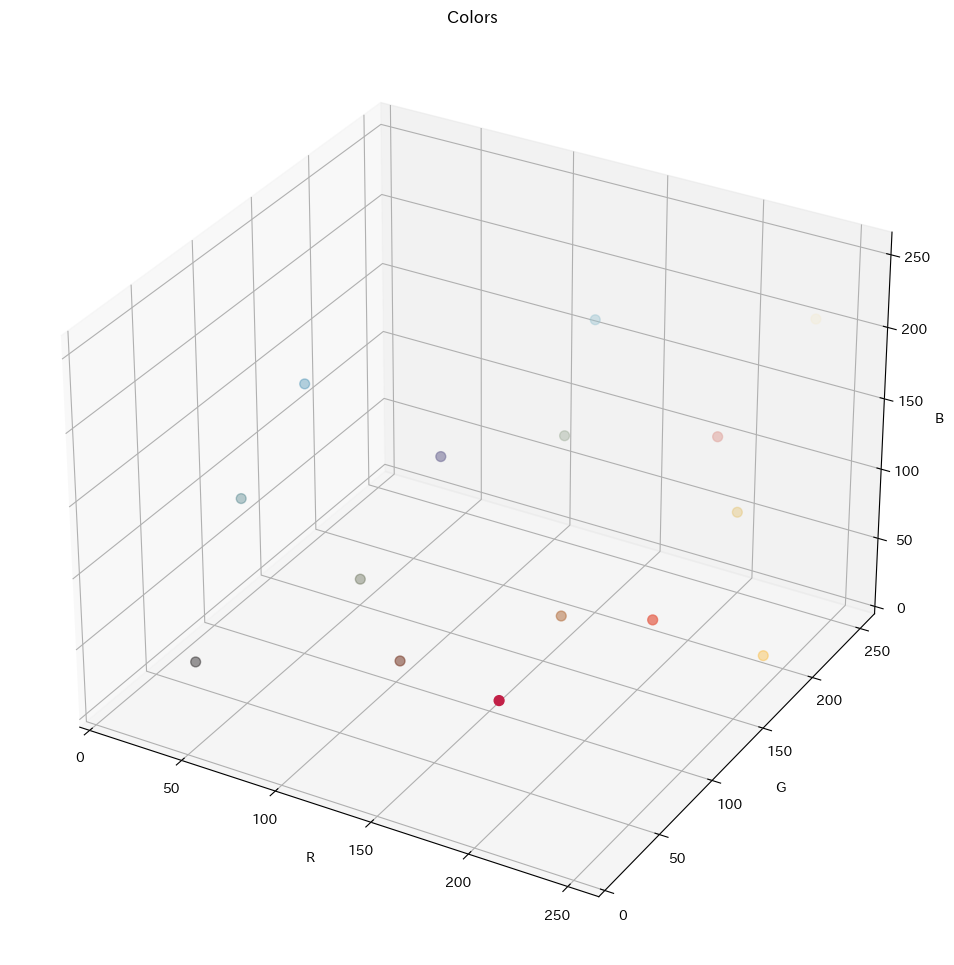

In [34]:
plot_colors(rep_points)

In [35]:
# 15のクラスタと各代表色を表示する
for i in rep_points:
    given_point = [df.iloc[i,0],df.iloc[i,1],df.iloc[i,2]]
    cluster_index = kmeans.predict([given_point])

    print("与えられた点が属するクラスタ:", cluster_index[0],":",df.iloc[i][3])

与えられた点が属するクラスタ: 0 : {'熨斗目色'}
与えられた点が属するクラスタ: 1 : {'bamboo'}
与えられた点が属するクラスタ: 2 : {'赤褐色'}
与えられた点が属するクラスタ: 3 : {'象牙色', 'アイボリー', 'ivoryivory white'}
与えられた点が属するクラスタ: 4 : {'深川鼠'}
与えられた点が属するクラスタ: 5 : {'土色'}
与えられた点が属するクラスタ: 6 : {'鉛丹色'}
与えられた点が属するクラスタ: 7 : {'呂色', '蝋色'}
与えられた点が属するクラスタ: 8 : {'花田色', 'シアン', '花色', '縹', '縹縹色', '中縹'}
与えられた点が属するクラスタ: 9 : {'薄藍'}
与えられた点が属するクラスタ: 10 : {'褪紅', '退紅'}
与えられた点が属するクラスタ: 11 : {'紫苑色'}
与えられた点が属するクラスタ: 12 : {'山吹色', '黄金色', 'イエローオレンジ', '黄橙', 'ゴールデンイエロー'}
与えられた点が属するクラスタ: 13 : {'唐紅（韓紅', '韓紅花）', '紅色'}
与えられた点が属するクラスタ: 14 : {'利休生壁'}


In [36]:
# 各クラスタに所属する点の情報を表示
for cluster_num, points in clusters.items():
    print(f"クラスタ {cluster_num} に所属する点:")
    print(points)

クラスタ 0 に所属する点:
        R      G      B                                                 名前  \
1    26.0   68.0  114.0  {Paris blue, プルシアンブルーほか, Prussian Blueプルシア藍, C...   
2    15.0   84.0  116.0                                        {インディゴ, 藍色}   
61    0.0   81.0   51.0                                              {暗緑色}   
71    0.0   63.0  142.0                                         {ink blue}   
74    7.0   71.0  112.0                                       {indigo, 藍色}   
110  48.0   88.0   59.0                              {常磐色, evergreen, 千歳緑}   
128  42.0  110.0  107.0                                 {御納戸茶, 納戸茶御納戸茶納戸鼠}   
149  43.0   76.0   90.0                                              {褐返し}   
156   0.0  105.0   86.0   {鴨の羽色ティールブルー, teal green, 鴨の羽色, ティールグリーンティールブルー}   
197   0.0   83.0   68.0                                               {鉄色}   
202   0.0  107.0   62.0                                     {chrome green}   
223  39.0   71.0  101.0                          

In [37]:
for cluster_num,points in clusters.items():
    # クラスタに所属する点の頻度を足し上げる
    cluster_freq_sum = clusters[cluster_num]['頻度'].sum()

    print("クラスタ",cluster_num,"に所属する点の頻度の合計:", cluster_freq_sum)

クラスタ 0 に所属する点の頻度の合計: 82.0
クラスタ 1 に所属する点の頻度の合計: 6.0
クラスタ 2 に所属する点の頻度の合計: 99.0
クラスタ 3 に所属する点の頻度の合計: 125.0
クラスタ 4 に所属する点の頻度の合計: 13.0
クラスタ 5 に所属する点の頻度の合計: 19.0
クラスタ 6 に所属する点の頻度の合計: 118.0
クラスタ 7 に所属する点の頻度の合計: 120.0
クラスタ 8 に所属する点の頻度の合計: 185.0
クラスタ 9 に所属する点の頻度の合計: 5.0
クラスタ 10 に所属する点の頻度の合計: 143.0
クラスタ 11 に所属する点の頻度の合計: 36.0
クラスタ 12 に所属する点の頻度の合計: 22.0
クラスタ 13 に所属する点の頻度の合計: 84.0
クラスタ 14 に所属する点の頻度の合計: 0.0


Text(0.5, 0, 'B')

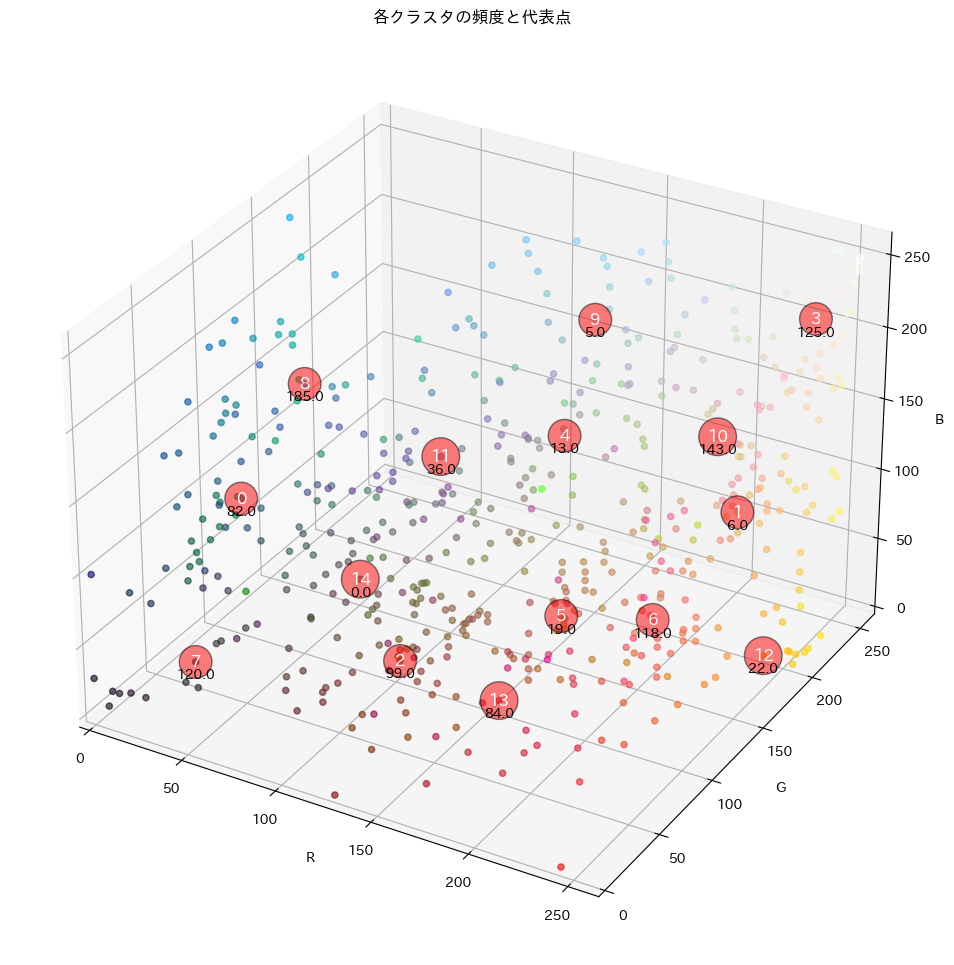

In [38]:
coords_of_points = np.array(coords_of_points)

# プロットの準備
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')

# color codeをその頂点の色にしたい
colors = df['色']

# クラスタの代表点をプロットし、クラスタ番号と頻度を表示
for cluster_num, rep_point in enumerate(rep_points):
    # クラスタ番号
    ax.text(
        coords_of_points[rep_point][0], coords_of_points[rep_point][1], coords_of_points[rep_point][2],
        f"{cluster_num}", bbox=dict(facecolor='red', alpha=0.5, boxstyle='circle,pad=0.5'),
        ha='center', va='center', fontsize=12, color='white'
    )
    # 頻度
    cluster_freq_sum = clusters[cluster_num]['頻度'].sum()
    ax.text(
        coords_of_points[rep_point][0], coords_of_points[rep_point][1], coords_of_points[rep_point][2] - 5,
        f"{cluster_freq_sum}",
        ha='center', va='top', fontsize=10, color='black'
    )
    
# 軸の範囲の設定
    ax.set_xlim([0, 260])
    ax.set_ylim([0, 260])
    ax.set_zlim([0, 260])

# Y軸の方向を逆にする
#ax.invert_xaxis()
    
# データポイントのプロット
ax.scatter(coords_of_points[:, 0], coords_of_points[:, 1], coords_of_points[:, 2], c=colors, cmap='viridis', alpha=0.6)

# プロットの装飾
ax.set_title('各クラスタの頻度と代表点')
ax.set_xlabel('R')
ax.set_ylabel('G')
ax.set_zlabel('B')

In [39]:
# 基本色がどのクラスタに所属するかを調べる
for i in basic_colors:
    given_point = [df.iloc[i,0],df.iloc[i,1],df.iloc[i,2]]
    cluster_index = kmeans.predict([given_point])

    print("与えられた点が属するクラスタ:", cluster_index[0],":",df.iloc[i][3])

与えられた点が属するクラスタ: 8 : {'ブルー', '蒼', '青', '碧', '藍'}
与えられた点が属するクラスタ: 8 : {'blue', '青'}
与えられた点が属するクラスタ: 8 : {'青緑色', 'ブルーグリーン', '青緑', 'blue green'}
与えられた点が属するクラスタ: 11 : {'purple blue', '青紫', 'バイオレット', 'パープルブルー'}
与えられた点が属するクラスタ: 11 : {'青紫', 'violet', '菫色'}
与えられた点が属するクラスタ: 13 : {'丹', '紅', '緋', '赤', 'レッド', '朱'}
与えられた点が属するクラスタ: 6 : {'赤', 'red'}
与えられた点が属するクラスタ: 10 : {'red purple', 'レッドパープル', '赤紫'}
与えられた点が属するクラスタ: 12 : {'jaune brillant', 'yellow', '黄色'}
与えられた点が属するクラスタ: 1 : {'yellow green', '黄緑色', '黄緑', 'イエローグリーン'}
与えられた点が属するクラスタ: 6 : {'イエローレッド', 'yellow red', '黄赤', 'オレンジ'}
与えられた点が属するクラスタ: 12 : {'orangeオレンジ色', '橙色', '黄赤', 'オレンジ'}
与えられた点が属するクラスタ: 12 : {'蒲公英色', '黄黄色', 'イエロー'}
与えられた点が属するクラスタ: 8 : {'緑', 'green'}
与えられた点が属するクラスタ: 0 : {'グリーン', '緑'}
与えられた点が属するクラスタ: 0 : {'翠', '緑'}
与えられた点が属するクラスタ: 7 : {'ブラック', '黒'}
与えられた点が属するクラスタ: 7 : {'black', '黒'}
与えられた点が属するクラスタ: 8 : {'cyancyan blue', 'シアン', '藍紫色'}
与えられた点が属するクラスタ: 3 : {'ホワイト', '白'}
与えられた点が属するクラスタ: 3 : {'white', '白'}
与えられた点が属するクラスタ: 11 : {'purple', '紫'}
与えられ

In [40]:
# どれぐらいのクラスタ数なら gray と purple や 青 と 青緑 を分類することができるのか?
# クラスタ数16ぐらいから始める

for n in range(16,31):
    
    print("クラスタ数 = ",n,"\n")
    
    kmeans = KMeans(n_clusters=n, random_state=0)
    kmeans.fit(coords_of_points)

    # クラスタの中心点を取得
    cluster_centers = kmeans.cluster_centers_

    # クラスタの代表点
    rep_points = []
    for point in cluster_centers:
        rep_points.append(closest_from_point(point))

    # n個のクラスタと各代表色を表示する
    for i in rep_points:
        given_point = [df.iloc[i,0],df.iloc[i,1],df.iloc[i,2]]
        cluster_index = kmeans.predict([given_point])

        print("与えられた点が属するクラスタ:", cluster_index[0],":",df.iloc[i][3])
    print("\n")

    # 基本色がどのクラスタに所属するかを調べる
    for i in basic_colors:
        given_point = [df.iloc[i,0],df.iloc[i,1],df.iloc[i,2]]
        cluster_index = kmeans.predict([given_point])

        print("与えられた点が属するクラスタ:", cluster_index[0],":",df.iloc[i][3])
    print("\n")

クラスタ数 =  16 

与えられた点が属するクラスタ: 0 : {'深川鼠'}
与えられた点が属するクラスタ: 1 : {'赤褐色'}
与えられた点が属するクラスタ: 2 : {'花田色', 'シアン', '花色', '縹', '縹縹色', '中縹'}
与えられた点が属するクラスタ: 3 : {'薄藍'}
与えられた点が属するクラスタ: 4 : {'salmon pink'}
与えられた点が属するクラスタ: 5 : {'呂色', '蝋色'}
与えられた点が属するクラスタ: 6 : {'エクルベージュ', '生成色'}
与えられた点が属するクラスタ: 7 : {'利休生壁'}
与えられた点が属するクラスタ: 8 : {'cadmium yellow'}
与えられた点が属するクラスタ: 9 : {'亜麻色', 'エクルベージュ'}
与えられた点が属するクラスタ: 10 : {'紫苑色'}
与えられた点が属するクラスタ: 11 : {'桃色', '桃色桃花色', 'ピーチブロッサム', 'ピンク', 'peach blossom'}
与えられた点が属するクラスタ: 12 : {'熨斗目色'}
与えられた点が属するクラスタ: 13 : {'韓紅', '韓紅花', '唐紅', '紅色'}
与えられた点が属するクラスタ: 14 : {'bamboo'}
与えられた点が属するクラスタ: 15 : {'焦香'}


与えられた点が属するクラスタ: 2 : {'ブルー', '蒼', '青', '碧', '藍'}
与えられた点が属するクラスタ: 2 : {'blue', '青'}
与えられた点が属するクラスタ: 2 : {'青緑色', 'ブルーグリーン', '青緑', 'blue green'}
与えられた点が属するクラスタ: 10 : {'purple blue', '青紫', 'バイオレット', 'パープルブルー'}
与えられた点が属するクラスタ: 10 : {'青紫', 'violet', '菫色'}
与えられた点が属するクラスタ: 13 : {'丹', '紅', '緋', '赤', 'レッド', '朱'}
与えられた点が属するクラスタ: 4 : {'赤', 'red'}
与えられた点が属するクラスタ: 11 : {'red purple', 'レッドパープル', '赤紫'}

与えられた点が属するクラスタ: 3 : {'翠', '緑'}
与えられた点が属するクラスタ: 12 : {'ブラック', '黒'}
与えられた点が属するクラスタ: 12 : {'black', '黒'}
与えられた点が属するクラスタ: 14 : {'cyancyan blue', 'シアン', '藍紫色'}
与えられた点が属するクラスタ: 4 : {'ホワイト', '白'}
与えられた点が属するクラスタ: 4 : {'white', '白'}
与えられた点が属するクラスタ: 2 : {'purple', '紫'}
与えられた点が属するクラスタ: 7 : {'パープル', '紫'}
与えられた点が属するクラスタ: 2 : {'灰色', 'ash grey'}
与えられた点が属するクラスタ: 19 : {'鼠色', '灰色', 'gray, grey'}
与えられた点が属するクラスタ: 2 : {'グレー', '鼠色', '灰色'}
与えられた点が属するクラスタ: 19 : {'グレー', '鼠色', '灰色'}


クラスタ数 =  21 

与えられた点が属するクラスタ: 0 : {'赤錆色'}
与えられた点が属するクラスタ: 1 : {'麹塵', '山鳩色', '青白橡'}
与えられた点が属するクラスタ: 2 : {'エクルベージュ', '生成色'}
与えられた点が属するクラスタ: 3 : {'虫襖', '玉虫色'}
与えられた点が属するクラスタ: 4 : {'土色'}
与えられた点が属するクラスタ: 5 : {'jasmine'}
与えられた点が属するクラスタ: 6 : {'billiard green'}
与えられた点が属するクラスタ: 7 : {'亜麻色', 'エクルベージュ'}
与えられた点が属するクラスタ: 8 : {'新橋色', '金春色'}
与えられた点が属するクラスタ: 9 : {'江戸紫'}
与えられた点が属するクラスタ: 10 : {'rose red'}
与えられた点が属するクラスタ: 11 : {'salmon pink'}
与えられた点が属するクラスタ: 12 : {'薄縹'}
与えられた点が属するクラスタ: 13 : {'呂色', '蝋色'}
与えられた点が属するクラスタ: 14 : {'crimson'}
与えられた点が属するクラスタ

与えられた点が属するクラスタ: 0 : {'韓紅', '韓紅花', '唐紅', '紅色'}
与えられた点が属するクラスタ: 1 : {'薄鼠'}
与えられた点が属するクラスタ: 2 : {'橡色'}
与えられた点が属するクラスタ: 3 : {'萌葱色', '萌木色', '萌黄萌黄色'}
与えられた点が属するクラスタ: 4 : {'メイズ', '玉蜀黍色', 'コーン'}
与えられた点が属するクラスタ: 5 : {'山吹色', '黄金色', 'イエローオレンジ', '黄橙', 'ゴールデンイエロー'}
与えられた点が属するクラスタ: 6 : {'檜皮色', '桧皮色'}
与えられた点が属するクラスタ: 7 : {'花田色', 'シアン', '花色', '縹', '縹縹色', '中縹'}
与えられた点が属するクラスタ: 8 : {'曙色', '東雲色'}
与えられた点が属するクラスタ: 9 : {'江戸茶'}
与えられた点が属するクラスタ: 10 : {'sky gray'}
与えられた点が属するクラスタ: 11 : {'呂色', '蝋色'}
与えられた点が属するクラスタ: 12 : {'根岸色'}
与えられた点が属するクラスタ: 13 : {'薄香'}
与えられた点が属するクラスタ: 14 : {'horizon blue'}
与えられた点が属するクラスタ: 15 : {'chocolatechocolate brown'}
与えられた点が属するクラスタ: 16 : {'エクルベージュ', '生成色'}
与えられた点が属するクラスタ: 17 : {'麹塵', '山鳩色', '青白橡'}
与えられた点が属するクラスタ: 18 : {'江戸紫'}
与えられた点が属するクラスタ: 19 : {'hunter green'}
与えられた点が属するクラスタ: 20 : {'インディゴ', '藍色'}
与えられた点が属するクラスタ: 21 : {'牡丹色'}
与えられた点が属するクラスタ: 22 : {'青緑色', 'ブルーグリーン', '青緑', 'blue green'}
与えられた点が属するクラスタ: 23 : {'緋色', 'scarlet'}
与えられた点が属するクラスタ: 24 : {'薄花色'}


与えられた点が属するクラスタ: 7 : {'ブルー', '蒼', 

与えられた点が属するクラスタ: 0 : {'crimson'}
与えられた点が属するクラスタ: 1 : {'鳩羽鼠', 'ダブグレイ', '鳩羽色'}
与えられた点が属するクラスタ: 2 : {'錆鼠'}
与えられた点が属するクラスタ: 3 : {'山葵色'}
与えられた点が属するクラスタ: 4 : {'Naples yellow'}
与えられた点が属するクラスタ: 5 : {'cadmium yellow'}
与えられた点が属するクラスタ: 6 : {'檜皮色', '桧皮色'}
与えられた点が属するクラスタ: 7 : {'blue', '青'}
与えられた点が属するクラスタ: 8 : {'曙色', '東雲色'}
与えられた点が属するクラスタ: 9 : {'江戸茶'}
与えられた点が属するクラスタ: 10 : {'sky gray'}
与えられた点が属するクラスタ: 11 : {'青褐'}
与えられた点が属するクラスタ: 12 : {'根岸色'}
与えられた点が属するクラスタ: 13 : {'薄香'}
与えられた点が属するクラスタ: 14 : {'horizon blue'}
与えられた点が属するクラスタ: 15 : {'chocolatechocolate brown'}
与えられた点が属するクラスタ: 16 : {'エクルベージュ', '生成色'}
与えられた点が属するクラスタ: 17 : {'麹塵', '山鳩色', '青白橡'}
与えられた点が属するクラスタ: 18 : {'江戸紫'}
与えられた点が属するクラスタ: 19 : {'hunter green'}
与えられた点が属するクラスタ: 20 : {'青藍'}
与えられた点が属するクラスタ: 21 : {'牡丹色'}
与えられた点が属するクラスタ: 22 : {'peacock blue'}
与えられた点が属するクラスタ: 23 : {'geranium red'}
与えられた点が属するクラスタ: 24 : {'浅縹'}
与えられた点が属するクラスタ: 25 : {'raw sienna'}
与えられた点が属するクラスタ: 26 : {'濡烏', '濡羽色', '烏羽色'}
与えられた点が属するクラスタ: 27 : {'萌葱色', '萌木色', '萌黄萌黄色'}
与えられた点が属するクラスタ: 28 : 

青と青緑はクラスタ数17で分けることができるが，  
purpleとash greyはぜんっぜん分けることができないマジで  
一応，クラスタ数17の時点でpurpleとパープルが分かれて，  
クラスタ数20でパープルとgrayが分かれ始めた．  

と，思ったら，なんか知らんけどクラスタ数21の時点で紫系統と灰色系統がめちゃくちゃ綺麗に分かれてる．  
でも青と青緑がくっついてる．

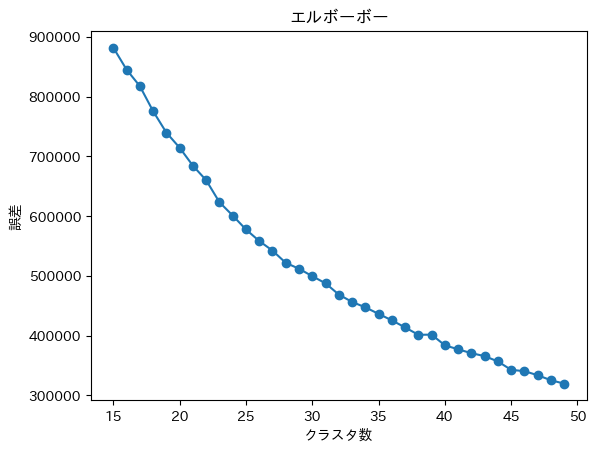

In [41]:
# エルボー法を用いて最適なクラスタ数を求めたい
# https://qiita.com/panda531/items/4b5504a3949eacb7ab19

# クラスタ数の範囲を定義
cluster_range = range(15, 50)

# 各クラスタ数でのクラスタ内誤差を保存するリスト
cluster_errors = []

# クラスタ数の範囲でK平均法を実行し、クラスタ内誤差を計算
for num_clusters in cluster_range:
    kmeans = KMeans(n_clusters=num_clusters, random_state=0)
    kmeans.fit(coords_of_points)
    cluster_errors.append(kmeans.inertia_)  # inertia_はクラスタ内誤差を示す属性

# クラスタ内誤差のプロット
plt.plot(cluster_range, cluster_errors, marker='o')
plt.xlabel('クラスタ数')
plt.ylabel('誤差')
plt.title('エルボーボー')
plt.show()

全然あかんやん

In [42]:
# クラスタ数21のときのやつも出しとく
# 関数化するのサボった
kmeans = KMeans(n_clusters=21, random_state=0)
kmeans.fit(coords_of_points)

# クラスタの中心点を取得
cluster_centers = kmeans.cluster_centers_

# クラスタの中心点を表示(最近点で近似)
rep_points = []
for point in cluster_centers:
    rep_points.append(closest_from_point(point))
for point in rep_points:
    print(df.iloc[point])
    
# 各点のクラスタラベルを取得
labels = kmeans.labels_

# 各クラスタに所属する点の情報を辞書にまとめる
clusters = {}
for cluster_num in range(21):
    clusters[cluster_num] = df[labels == cluster_num]

R       132.0
G        51.0
B        31.0
名前      {赤錆色}
色     #84331F
頻度        0.0
Name: 26, dtype: object
R              131.0
G              134.0
B              108.0
名前    {麹塵, 山鳩色, 青白橡}
色            #83866C
頻度               0.0
Name: 15, dtype: object
R              246.0
G              245.0
B              234.0
名前    {エクルベージュ, 生成色}
色            #F6F5EA
頻度               0.0
Name: 175, dtype: object
R          58.0
G          91.0
B          82.0
名前    {虫襖, 玉虫色}
色       #3A5B52
頻度          NaN
Name: 497, dtype: object
R       180.0
G       113.0
B        66.0
名前       {土色}
色     #B47142
頻度        0.0
Name: 343, dtype: object
R         235.0
G         201.0
B         118.0
名前    {jasmine}
色       #EBC976
頻度          3.0
Name: 269, dtype: object
R                  0.0
G                 93.0
B                 77.0
名前    {billiard green}
色              #005D4D
頻度                 0.0
Name: 426, dtype: object
R              232.0
G              218.0
B              190.0
名前    {亜麻色, エク

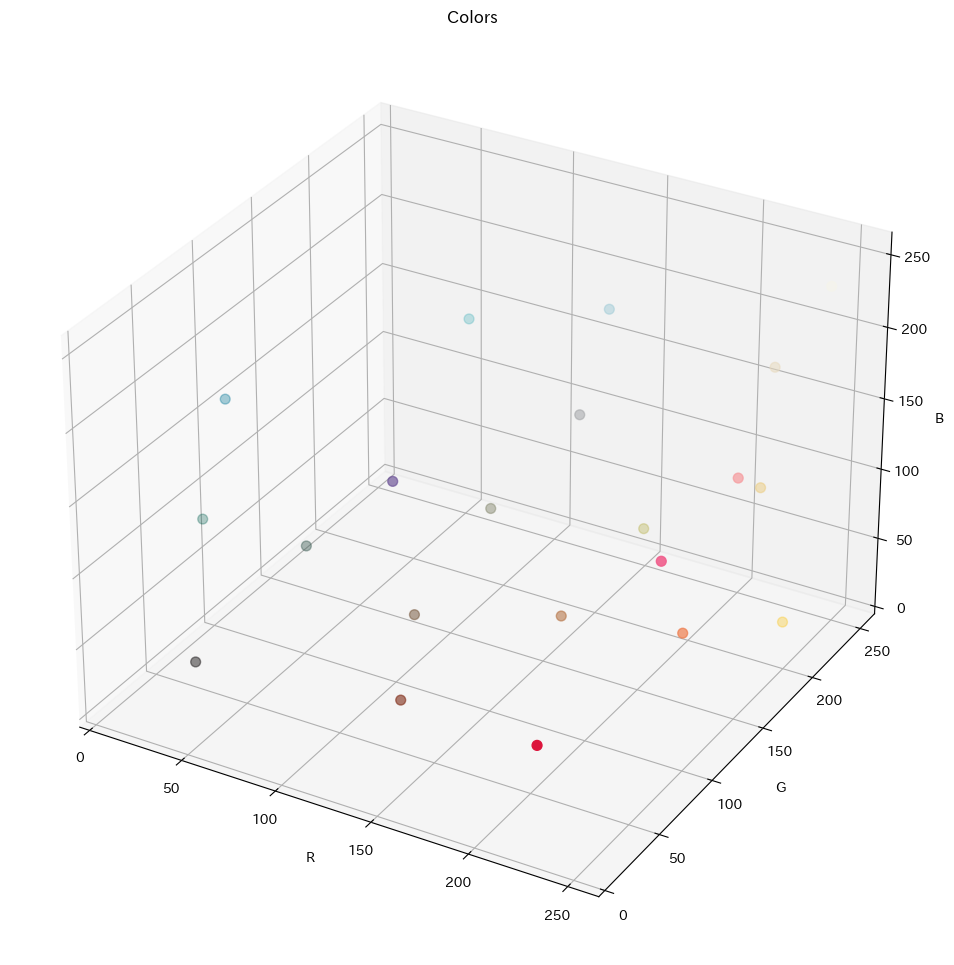

In [43]:
plot_colors(rep_points)

In [44]:
# 21のクラスタと各代表色を表示する
for i in rep_points:
    given_point = [df.iloc[i,0],df.iloc[i,1],df.iloc[i,2]]
    cluster_index = kmeans.predict([given_point])

    print("与えられた点が属するクラスタ:", cluster_index[0],":",df.iloc[i][3])

与えられた点が属するクラスタ: 0 : {'赤錆色'}
与えられた点が属するクラスタ: 1 : {'麹塵', '山鳩色', '青白橡'}
与えられた点が属するクラスタ: 2 : {'エクルベージュ', '生成色'}
与えられた点が属するクラスタ: 3 : {'虫襖', '玉虫色'}
与えられた点が属するクラスタ: 4 : {'土色'}
与えられた点が属するクラスタ: 5 : {'jasmine'}
与えられた点が属するクラスタ: 6 : {'billiard green'}
与えられた点が属するクラスタ: 7 : {'亜麻色', 'エクルベージュ'}
与えられた点が属するクラスタ: 8 : {'新橋色', '金春色'}
与えられた点が属するクラスタ: 9 : {'江戸紫'}
与えられた点が属するクラスタ: 10 : {'rose red'}
与えられた点が属するクラスタ: 11 : {'salmon pink'}
与えられた点が属するクラスタ: 12 : {'薄縹'}
与えられた点が属するクラスタ: 13 : {'呂色', '蝋色'}
与えられた点が属するクラスタ: 14 : {'crimson'}
与えられた点が属するクラスタ: 15 : {'柳茶', '威光茶'}
与えられた点が属するクラスタ: 16 : {'銀鼠', 'silver gray', '銀灰色', 'シルバーグレー'}
与えられた点が属するクラスタ: 17 : {'cadmium yellow'}
与えられた点が属するクラスタ: 18 : {'紅梅色'}
与えられた点が属するクラスタ: 19 : {'burnt umber'}
与えられた点が属するクラスタ: 20 : {'duck blue', '鴨の羽色ティールブルー'}


In [45]:
for cluster_num,points in clusters.items():
    # クラスタに所属する点の頻度を足し上げる
    cluster_freq_sum = clusters[cluster_num]['頻度'].sum()

    print("クラスタ",cluster_num,"に所属する点の頻度の合計:", cluster_freq_sum)

クラスタ 0 に所属する点の頻度の合計: 67.0
クラスタ 1 に所属する点の頻度の合計: 16.0
クラスタ 2 に所属する点の頻度の合計: 124.0
クラスタ 3 に所属する点の頻度の合計: 3.0
クラスタ 4 に所属する点の頻度の合計: 19.0
クラスタ 5 に所属する点の頻度の合計: 6.0
クラスタ 6 に所属する点の頻度の合計: 79.0
クラスタ 7 に所属する点の頻度の合計: 6.0
クラスタ 8 に所属する点の頻度の合計: 2.0
クラスタ 9 に所属する点の頻度の合計: 22.0
クラスタ 10 に所属する点の頻度の合計: 8.0
クラスタ 11 に所属する点の頻度の合計: 131.0
クラスタ 12 に所属する点の頻度の合計: 3.0
クラスタ 13 に所属する点の頻度の合計: 120.0
クラスタ 14 に所属する点の頻度の合計: 85.0
クラスタ 15 に所属する点の頻度の合計: 11.0
クラスタ 16 に所属する点の頻度の合計: 0.0
クラスタ 17 に所属する点の頻度の合計: 0.0
クラスタ 18 に所属する点の頻度の合計: 138.0
クラスタ 19 に所属する点の頻度の合計: 32.0
クラスタ 20 に所属する点の頻度の合計: 185.0


Text(0.5, 0, 'B')

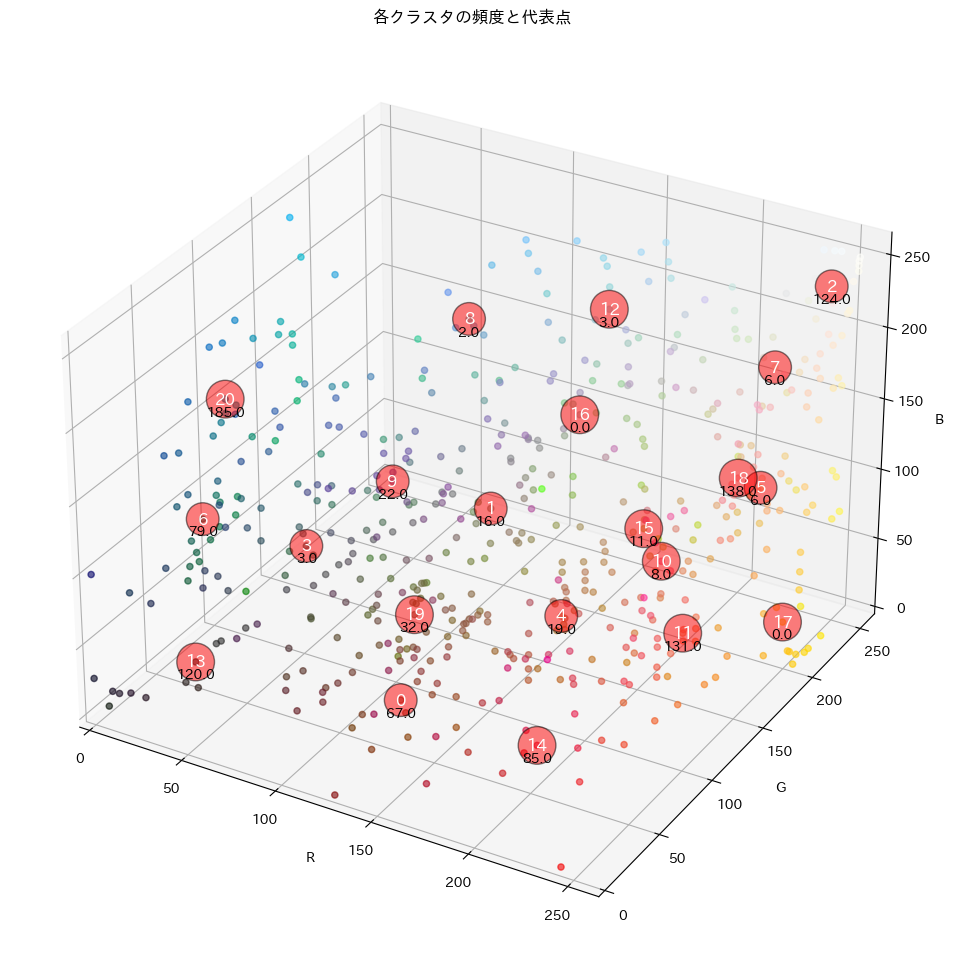

In [46]:
# プロットの準備
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')

# color codeをその頂点の色にしたい
colors = df['色']

# クラスタの代表点をプロットし、クラスタ番号と頻度を表示
for cluster_num, rep_point in enumerate(rep_points):
    # クラスタ番号
    ax.text(
        coords_of_points[rep_point][0], coords_of_points[rep_point][1], coords_of_points[rep_point][2],
        f"{cluster_num}", bbox=dict(facecolor='red', alpha=0.5, boxstyle='circle,pad=0.5'),
        ha='center', va='center', fontsize=12, color='white'
    )
    # 頻度
    cluster_freq_sum = clusters[cluster_num]['頻度'].sum()
    ax.text(
        coords_of_points[rep_point][0], coords_of_points[rep_point][1], coords_of_points[rep_point][2] - 5,
        f"{cluster_freq_sum}",
        ha='center', va='top', fontsize=10, color='black'
    )
    
# 軸の範囲の設定
    ax.set_xlim([0, 260])
    ax.set_ylim([0, 260])
    ax.set_zlim([0, 260])
    
# データポイントのプロット
ax.scatter(coords_of_points[:, 0], coords_of_points[:, 1], coords_of_points[:, 2], c=colors, cmap='viridis', alpha=0.6)

# プロットの装飾
ax.set_title('各クラスタの頻度と代表点')
ax.set_xlabel('R')
ax.set_ylabel('G')
ax.set_zlabel('B')